# Standard Plotting Suite for Mass Spectrometry Models

This notebook provides standardized 2x2 plotting suites for evaluating mass spectrometry prediction models. It serves as the canonical reference for model evaluation visualizations across all training pipelines.

### Quick Reference:
- **Traditional ML**: Cells 7 + 8
- **Deep Learning**: Cells 7 + 8 + 10

## Visualization Suites:

### 1. Standard 2x2 Diagnostic Plots (Cell 7):
- **Cosine Similarity Distribution** (Top-Left): Overall performance distribution
- **Performance by m/z Range** (Top-Right): Cosine similarity with model + statistical uncertainty
- **Intensity Correlation** (Bottom-Left): True vs predicted intensity scatter plot with density visualization
- **Peak Count Comparison** (Bottom-Right): Average peaks per spectrum by m/z range

### 2. Random Spectrum Visualization (Cell 8):
- **Random Spectrum Examples** (2x2 Grid): Visual comparison of experimental vs predicted spectra with molecular structures

### 3. Deep Learning Training Plots (Cell 10):
- **Loss Curves** (Top-Left): Training and validation loss over epochs
- **Cosine Similarity** (Top-Right): Validation cosine similarity progression
- **Peak Detection F1** (Bottom-Left): Peak detection performance over training
- **Learning Rate Schedule** (Bottom-Right): Learning rate changes during training

### Key Features:
- **Traditional ML**: Random Forest with uncertainty quantification
- **Deep Learning**: Neural network with training history tracking
- **Simple Integration**: Copy functions directly into other notebooks
- **Efficient for Many Models**: Optimized for evaluating 88+ models

**Input Requirements**: Featurized JSONL data from notebook 03

**Output**: Standardized diagnostic plots for each model type

## 1. Environment Setup

Import required libraries and configure plotting defaults.

### Key Components:
- **scikit-learn**: Random Forest and evaluation metrics
- **PyTorch**: Deep learning models and training
- **NumPy**: Numerical operations
- **Matplotlib**: Visualization
- **SciPy**: Cosine similarity calculations
- **RDKit**: Molecular structure visualization (optional)

In [83]:
# Standard library imports
import os
import json
import pickle
import warnings
import io
import random
from typing import Dict, Tuple, List, Optional, Any

# Data science imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from scipy.spatial.distance import cosine

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    median_absolute_error, explained_variance_score
)

# Deep learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Chemistry imports (optional)
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import rdMolDraw2D
    RDKIT_AVAILABLE = True
    print("RDKit available for molecular structure visualization")
except ImportError:
    RDKIT_AVAILABLE = False
    print("Warning: RDKit not available. Molecular structure features will be limited.")

# Configure warnings
warnings.filterwarnings('ignore')

# Configure plotting defaults
plt.rcParams.update({
    'figure.figsize': (12, 10),
    'figure.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration for PyTorch
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"PyTorch device: {DEVICE}")

print("Environment setup complete")

RDKit available for molecular structure visualization
PyTorch device: mps
Environment setup complete


## 2. Configuration

Central configuration for paths, model parameters, and evaluation settings.

### Configuration Parameters:

**Data Settings:**
- `transform_sqrt`: Apply $y \rightarrow \sqrt{y}$ transformation
- `random_state`: Reproducibility seed

**Random Forest:**
- Simplified parameters for demonstration
- 50 trees for faster training while maintaining uncertainty estimates

**Neural Network:**
- Simple MLP architecture for demonstration
- Training hyperparameters (epochs, learning rate, etc.)

**Evaluation:**
- `mz_step`: 50 bin windows for m/z analysis
- `peak_threshold`: 0.01 intensity threshold for peak detection

In [84]:
MASTER_CONFIG = {
    # Paths configuration
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models',
        'input_type': 'hpj',
        'use_selected_data': False,
        'data_subdir': lambda use_sel: 'selected' if use_sel else 'full_featurised'
    },
    
    # Data settings
    'data': {
        'random_state': 42,
        'transform_sqrt': True,  # Apply sqrt transformation to targets
    },
    
    # Simplified Random Forest for demo
    'rf': {
        'n_estimators': 50,  # Enough trees for uncertainty estimation
        'max_depth': 20,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'n_jobs': -1
    },
    
    # Neural Network configuration
    'nn': {
        'hidden_dims': [2048, 1024, 512],
        'dropout': 0.2,
        'batch_norm': True,
        'batch_size': 64,
        'epochs': 50,  # Reduced for demo
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'early_stopping_patience': 10,
        'lr_scheduler_patience': 5,
        'lr_scheduler_factor': 0.5,
        'gradient_clip': 1.0
    },
    
    # Evaluation settings
    'evaluation': {
        'mz_step': 50,
        'max_mz': 1000,
        'peak_threshold': 0.01,
        'eval_frequency': 5  # Evaluate every N epochs for NN
    }
}

# Create output directory
os.makedirs(MASTER_CONFIG['paths']['models_dir'], exist_ok=True)
print(f"Configuration loaded. Models directory: {MASTER_CONFIG['paths']['models_dir']}")

Configuration loaded. Models directory: ../models


## 3. Data Loading Functions

Functions for loading JSONL data containing molecular features and target spectra.

### Data Format:
- `smiles`: Molecular SMILES string
- `features`: Feature vector
- `target`: Mass spectrum intensities

In [85]:
def get_data_paths(config):
    """Get data file paths based on configuration."""
    input_type_dir = os.path.join(config['paths']['results_dir'], config['paths']['input_type'])
    data_dir = os.path.join(input_type_dir, config['paths']['data_subdir'](config['paths']['use_selected_data']))
    
    return {
        'train': os.path.join(data_dir, 'train_data.jsonl'),
        'val': os.path.join(data_dir, 'val_data.jsonl'),
        'test': os.path.join(data_dir, 'test_data.jsonl')
    }

def load_jsonl_data(filepath):
    """Load data from JSONL file."""
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)
    
    # Count lines for progress bar
    with open(filepath, 'r') as f:
        total_lines = sum(1 for _ in f)
    
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}", 
                       total=total_lines, unit="spectra"):
            try:
                record = json.loads(line)
                smiles = record.get("smiles")
                feat = record.get("features")
                targ = record.get("target")
                
                if smiles and feat is not None and targ is not None:
                    smiles_list.append(smiles)
                    features.append(feat)
                    targets.append(targ)
            except (json.JSONDecodeError, KeyError) as e:
                continue
    
    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)

def create_torch_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    """Create PyTorch DataLoaders for neural network training."""
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).float()
    )
    val_dataset = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(y_val).float()
    )
    test_dataset = TensorDataset(
        torch.from_numpy(X_test).float(),
        torch.from_numpy(y_test).float()
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

print("Data loading functions ready")

Data loading functions ready


## 4. Evaluation Metrics

Core evaluation functions including uncertainty quantification.

### Metrics:

**Cosine Similarity**: 
$$\text{cosine\_sim}(y, \hat{y}) = \frac{y \cdot \hat{y}}{||y|| \cdot ||\hat{y}||}$$

**Weighted Dot Product (WDP)**:
$$\text{WDP}(y, \hat{y}) = \frac{\sum_{i} w_i \cdot y_i \cdot \hat{y}_i}{\sum_{i} w_i \cdot y_i^2}$$

**Peak Detection Metrics**:
- Precision, Recall, F1 Score for peak presence prediction

**Model Uncertainty** (Epistemic - RF only):
- Variance across Random Forest trees
- Indicates model confidence

**Statistical Uncertainty** (Aleatoric):
- Standard error across samples
- Represents data variability

In [ ]:
def cosine_similarity_matrix(y_true, y_pred):
    """Calculate cosine similarity between true and predicted spectra."""
    similarities = []
    for i in range(len(y_true)):
        true_spec = y_true[i]
        pred_spec = y_pred[i]
        
        if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
            cos_sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
        else:
            cos_sim = 1 - cosine(true_spec, pred_spec)
        
        similarities.append(cos_sim if not np.isnan(cos_sim) else 0)
    
    return np.mean(similarities), np.array(similarities)

def weighted_dot_product(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    """Calculate weighted dot product (WDP) score."""
    weights = y_true + eps
    numerator = np.sum(weights * y_true * y_pred)
    denominator = np.sum(weights * y_true * y_true) + eps
    return numerator / denominator

def peak_detection_metrics(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.01) -> Dict:
    """Calculate peak detection metrics."""
    # Normalize to relative intensities
    y_true_norm = y_true / (np.max(y_true, axis=1, keepdims=True) + 1e-8)
    y_pred_norm = y_pred / (np.max(y_pred, axis=1, keepdims=True) + 1e-8)
    
    # Binary masks for peaks
    true_peaks = y_true_norm > threshold
    pred_peaks = y_pred_norm > threshold
    
    # Calculate metrics
    tp = np.sum(true_peaks & pred_peaks)
    fp = np.sum(~true_peaks & pred_peaks)
    fn = np.sum(true_peaks & ~pred_peaks)
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def get_model_predictions_with_uncertainty(model, X_scaled):
    """Get predictions with model uncertainty from Random Forest.
    
    Returns:
        y_pred: Mean predictions across trees
        y_pred_all: All tree predictions for uncertainty calculation
    """
    if hasattr(model, 'estimators_'):  # Random Forest
        # Get predictions from each tree
        tree_predictions = np.array([tree.predict(X_scaled) for tree in model.estimators_])
        y_pred = np.mean(tree_predictions, axis=0)
        return y_pred, tree_predictions
    else:
        # Fallback for non-ensemble models
        y_pred = model.predict(X_scaled)
        return y_pred, None

def cosine_similarity_by_mz_range_with_uncertainty(y_true, y_pred, tree_predictions, config):
    """Calculate cosine similarity by m/z range with model and statistical uncertainty.
    
    Uses actual predictions for similarity/peak counts. For ensembles, per-tree
    predictions are used only to estimate model uncertainty.
    """
    spectrum_length = y_true.shape[1]
    step_size = config['evaluation']['mz_step']
    max_mz = min(config['evaluation']['max_mz'], spectrum_length)
    
    # Use actual predictions; for ensembles, mean across trees for primary curve
    y_mean_pred = np.mean(tree_predictions, axis=0) if tree_predictions is not None else y_pred
    
    mz_ranges = {}
    for start in range(0, max_mz, step_size):
        end = min(start + step_size, max_mz)
        range_key = f"{start}-{end}"
        
        y_true_range = y_true[:, start:end]
        y_pred_range = y_mean_pred[:, start:end]
        
        # Mean cosine similarity across samples
        similarities = []
        for i in range(len(y_true)):
            t = y_true_range[i]
            p = y_pred_range[i]
            if np.sum(t) == 0 or np.sum(p) == 0:
                sim = 0 if np.sum(t) != np.sum(p) else 1
            else:
                sim = 1 - cosine(t, p)
            similarities.append(sim)
        mean_sim = np.mean(similarities)
        
        # Statistical uncertainty (SE) across samples
        stat_uncertainty = np.std(similarities) / np.sqrt(len(similarities)) if len(similarities) > 1 else 0.0
        
        # Model uncertainty: variability across trees (if available)
        if tree_predictions is not None:
            tree_sims = []
            for b in range(tree_predictions.shape[0]):
                p_b = tree_predictions[b, :, start:end]
                sims_b = []
                for i in range(len(y_true)):
                    t = y_true_range[i]
                    p = p_b[i]
                    if np.sum(t) == 0 or np.sum(p) == 0:
                        s = 0 if np.sum(t) != np.sum(p) else 1
                    else:
                        s = 1 - cosine(t, p)
                    sims_b.append(s)
                tree_sims.append(np.mean(sims_b))
            model_uncertainty = np.std(tree_sims)
        else:
            model_uncertainty = 0.0
        
        # Peak counts (on the same predictions used above)
        true_peaks = np.sum(y_true_range > config['evaluation']['peak_threshold'])
        pred_peaks = np.sum(y_pred_range > config['evaluation']['peak_threshold'])
        
        non_zero_samples = np.sum(np.sum(y_true_range, axis=1) > 0)
        coverage = non_zero_samples / len(y_true) * 100
        
        mz_ranges[range_key] = {
            'mean_similarity': mean_sim,
            'stat_uncertainty': stat_uncertainty,
            'model_uncertainty': model_uncertainty,
            'coverage': coverage,
            'avg_true_peaks_per_spectrum': true_peaks / len(y_true),
            'avg_pred_peaks_per_spectrum': pred_peaks / len(y_true),
        }
    return mz_ranges

def evaluate_model(y_true, y_pred, tree_predictions, config, model_name="Model"):
    """Comprehensive model evaluation with uncertainties."""
    # Calculate standard metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    explained_var = explained_variance_score(y_true, y_pred)
    
    # Calculate cosine similarity
    mean_cosine_sim, all_cosine_sims = cosine_similarity_matrix(y_true, y_pred)
    
    # Calculate cosine similarity by m/z range with uncertainties
    mz_range_sims = cosine_similarity_by_mz_range_with_uncertainty(
        y_true, y_pred, tree_predictions, config
    )
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"  Cosine Similarity: {mean_cosine_sim:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Median AE: {median_ae:.4f}")
    print(f"  Max Error: {max_err:.4f}")
    print(f"  Explained Variance: {explained_var:.4f}")
    
    return {
        'cosine': mean_cosine_sim,
        'y_pred': y_pred,
        'y_true': y_true,
        'tree_predictions': tree_predictions,
        'individual_cos_sims': all_cosine_sims,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'median_ae': median_ae,
        'max_err': max_err,
        'explained_var': explained_var,
        'mz_range_sims': mz_range_sims
    }

print("Evaluation functions with uncertainty quantification loaded")

Evaluation functions with uncertainty quantification loaded


## 5. Data Loading and Model Training

Load data and train both Random Forest and Neural Network models for demonstration.

### Process:
1. Load JSONL data files
2. Apply preprocessing (scaling, transformation)
3. Train Random Forest model
4. Train Neural Network model
5. Extract predictions with uncertainty (RF) and training history (NN)

In [87]:
print("LOADING DATA AND TRAINING MODELS")
print("=" * 60)

# Get data paths
data_paths = get_data_paths(MASTER_CONFIG)

# Load training and test data
print("\nLoading datasets...")
train_smiles, X_train, y_train = load_jsonl_data(data_paths['train'])
val_smiles, X_val, y_val = load_jsonl_data(data_paths['val'])
test_smiles, X_test, y_test = load_jsonl_data(data_paths['test'])

# Check if data was loaded successfully
if len(X_train) == 0 or len(X_test) == 0:
    print("\nWarning: No real data found. Creating synthetic data for demonstration...")
    # Create synthetic data
    np.random.seed(MASTER_CONFIG['data']['random_state'])
    n_train, n_val, n_test = 500, 100, 100
    n_features, n_bins = 100, 500
    
    X_train = np.random.randn(n_train, n_features)
    X_val = np.random.randn(n_val, n_features)
    X_test = np.random.randn(n_test, n_features)
    
    # Create synthetic spectra with realistic sparsity
    y_train = np.zeros((n_train, n_bins))
    y_val = np.zeros((n_val, n_bins))
    y_test = np.zeros((n_test, n_bins))
    
    for i in range(n_train):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_train[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    for i in range(n_val):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_val[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    for i in range(n_test):
        n_peaks = np.random.randint(5, 20)
        peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
        y_test[i, peak_positions] = np.random.exponential(0.5, n_peaks)
    
    # Create synthetic SMILES (placeholder)
    test_smiles = ['N/A'] * n_test
    
    print(f"Created synthetic data: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
else:
    print(f"\nData loaded successfully:")
    print(f"  Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Test: {X_test.shape[0]} samples")
    print(f"  Spectrum dimensions: {y_train.shape[1]} bins")

# Store dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

LOADING DATA AND TRAINING MODELS

Loading datasets...


Loading train_data.jsonl: 100%|██████████| 2176/2176 [00:02<00:00, 1068.98spectra/s]


Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 1115.19spectra/s]


Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 1098.22spectra/s]


Loaded 272 samples from test_data.jsonl

Data loaded successfully:
  Training: 2176 samples, 7137 features
  Validation: 272 samples
  Test: 272 samples
  Spectrum dimensions: 500 bins


## 6. Random Forest Training

Train Random Forest and extract both predictions and model uncertainty.

### Uncertainty Sources:

**Model Uncertainty** (Epistemic):
- Variance across Random Forest trees
- High where training data is sparse

**Statistical Uncertainty** (Aleatoric):
- Inherent data variability
- Cannot be reduced with more data

In [88]:
print("\nTRAINING RANDOM FOREST MODEL")
print("-" * 40)

# Apply transformation if configured
if MASTER_CONFIG['data']['transform_sqrt']:
    print("Applying square root transformation...")
    y_train_transformed = np.sqrt(y_train)
    y_val_transformed = np.sqrt(y_val)
    y_test_transformed = np.sqrt(y_test)
else:
    y_train_transformed = y_train
    y_val_transformed = y_val
    y_test_transformed = y_test

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create and train Random Forest model
print(f"\nTraining Random Forest with {MASTER_CONFIG['rf']['n_estimators']} trees...")
rf_model = RandomForestRegressor(
    n_estimators=MASTER_CONFIG['rf']['n_estimators'],
    max_depth=MASTER_CONFIG['rf']['max_depth'],
    min_samples_split=MASTER_CONFIG['rf']['min_samples_split'],
    min_samples_leaf=MASTER_CONFIG['rf']['min_samples_leaf'],
    random_state=MASTER_CONFIG['data']['random_state'],
    n_jobs=MASTER_CONFIG['rf']['n_jobs'],
    verbose=0
)

# Train the model
rf_model.fit(X_train_scaled, y_train_transformed)
print("Model training complete")

# Generate predictions with uncertainty
print("\nGenerating predictions with uncertainty quantification...")
y_test_pred, tree_predictions = get_model_predictions_with_uncertainty(rf_model, X_test_scaled)
y_test_pred = np.maximum(y_test_pred, 0)  # Ensure non-negative predictions

# Calculate model uncertainty statistics
if tree_predictions is not None:
    model_std = np.std(tree_predictions, axis=0)
    print(f"Model uncertainty statistics:")
    print(f"  Mean uncertainty across all predictions: {np.mean(model_std):.4f}")
    print(f"  Max uncertainty: {np.max(model_std):.4f}")
    print(f"  Min uncertainty: {np.min(model_std):.4f}")

# Evaluate model
results = evaluate_model(y_test_transformed, y_test_pred, tree_predictions, 
                        MASTER_CONFIG, "Random Forest")

print("\nRandom Forest evaluation complete")


TRAINING RANDOM FOREST MODEL
----------------------------------------
Applying square root transformation...
Scaling features...

Training Random Forest with 50 trees...
Model training complete

Generating predictions with uncertainty quantification...
Model uncertainty statistics:
  Mean uncertainty across all predictions: 0.0390
  Max uncertainty: 0.4974
  Min uncertainty: 0.0000

Random Forest Performance:
  Cosine Similarity: 0.7765
  MSE: 0.0045
  R2 Score: 0.1263
  MAE: 0.0249
  Median AE: 0.0114
  Max Error: 1.0000
  Explained Variance: 0.1329

Random Forest evaluation complete


## 7. Standard 2x2 Diagnostic Plots

**ALL PLOTTING CODE IN ONE CELL** - Modify and re-run this cell to update plots without retraining.

### Plot Descriptions:

**1. Cosine Similarity Distribution** (Top-Left):
- Histogram of per-sample similarities
- Red line shows mean performance

**2. Performance by m/z Range** (Top-Right):
- Blue line: Mean cosine similarity
- Purple band: Model uncertainty (variance across trees)
- Yellow hatched band: Statistical uncertainty (standard error)

**3. Intensity Correlation** (Bottom-Left):
- Scatter plot with violin density visualization
- Red diagonal: Perfect prediction line

**4. Peak Count Comparison** (Bottom-Right):
- Green bars: True peak counts
- Blue bars: Predicted peak counts

AGENT = ENSURE YOU CLIP BOTTOM LEFT INTENSITY CORR SUBPLOT TO 1, AS 1 IS THE MAX INTENSITY (SOMETIMES THIS PLOT GOES TO 2 BY MISTAKE)


GENERATING STANDARD 2x2 DIAGNOSTIC PLOTS


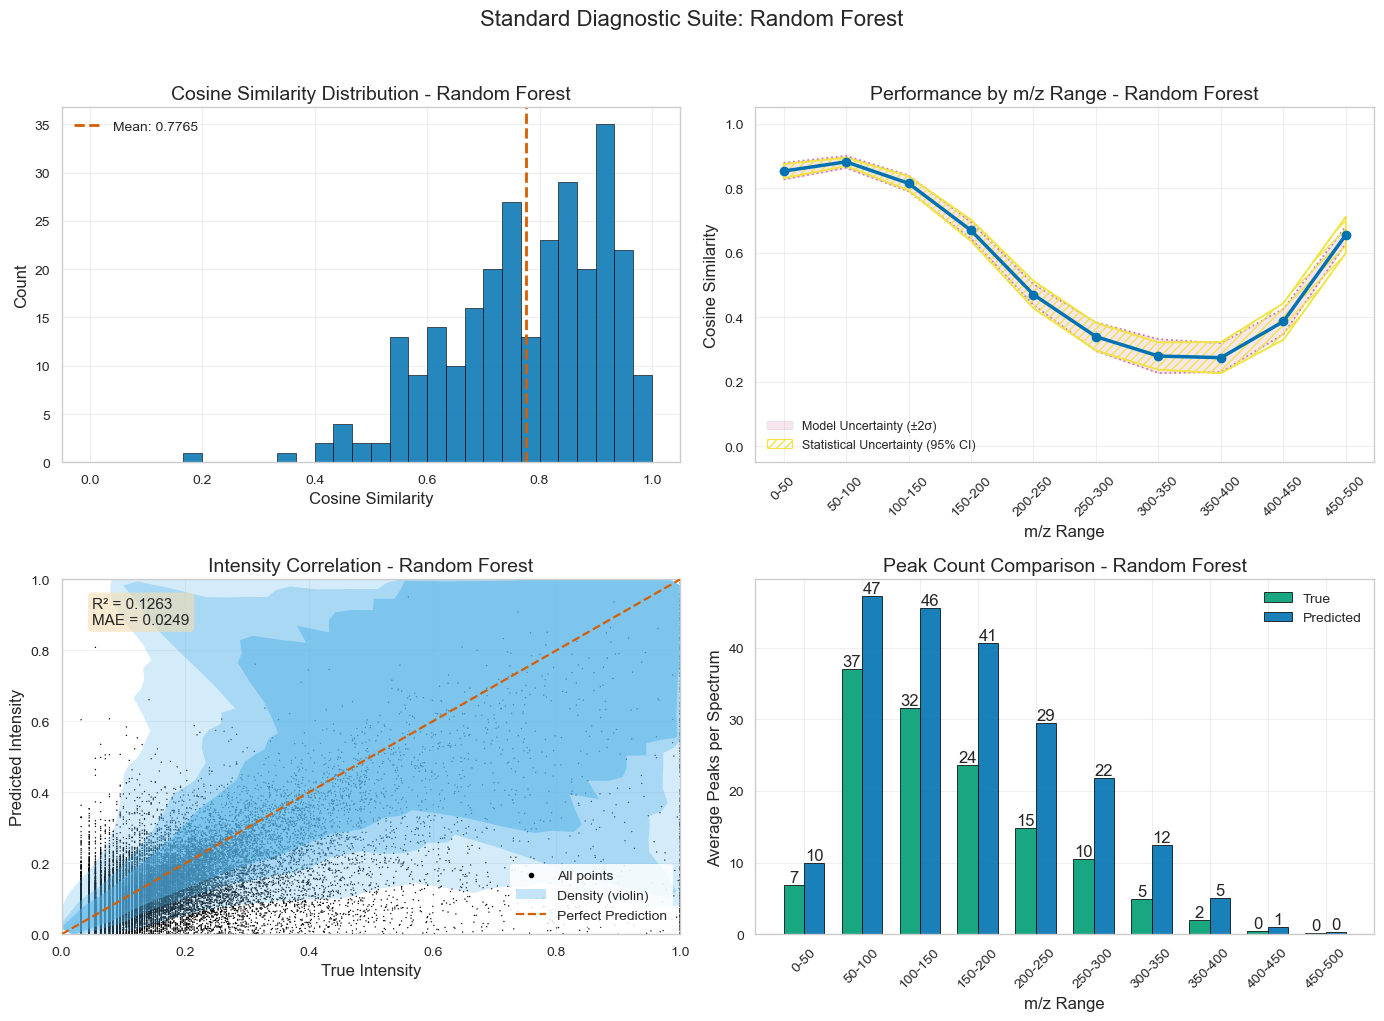


Plotting complete


In [ ]:
# ============================================================================
# STANDARD 2x2 PLOTTING SUITE - ALL PLOTTING CODE IN ONE CELL
# ============================================================================

# Colorblind-friendly Okabe–Ito palette
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

def visualize_results(results, model_name="Model", show_uncertainties=True):
    """Create standard 2x2 evaluation visualization.
    
    Args:
        results: Dictionary from evaluate_model()
        model_name: Name for plot title
        show_uncertainties: Whether to show uncertainty bands
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ---------- Top-Left: Cosine Similarity Distribution ----------
    ax = axes[0, 0]
    ax.hist(results['individual_cos_sims'], bins=30, range=(0, 1),
            alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.set_title(f'Cosine Similarity Distribution - {model_name}')
    ax.axvline(results['cosine'], color=PALETTE["vermillion"], linestyle='--', linewidth=2,
               label=f"Mean: {results['cosine']:.4f}")
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    # ---------- Top-Right: Performance by m/z with Uncertainties ----------
    ax = axes[0, 1]
    ranges = list(results['mz_range_sims'].keys())
    x_pos = np.arange(len(ranges))
    mean_sims = np.array([results['mz_range_sims'][r]['mean_similarity'] for r in ranges])
    stat_uncertainties = np.array([results['mz_range_sims'][r]['stat_uncertainty'] for r in ranges])
    model_uncertainties = np.array([results['mz_range_sims'][r]['model_uncertainty'] for r in ranges])
    
    if show_uncertainties:
        legend_handles = []
        # Statistical uncertainty (95% CI)
        if np.any(stat_uncertainties > 0):
            stat_ci = 1.96 * stat_uncertainties
            stat_lower = np.clip(mean_sims - stat_ci, 0, 1)
            stat_upper = np.clip(mean_sims + stat_ci, 0, 1)
            ax.fill_between(x_pos, stat_lower, stat_upper,
                            facecolor='none', edgecolor=PALETTE["yellow"],
                            hatch='////', linewidth=1.2, zorder=3)
            ax.plot(x_pos, stat_lower, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
            ax.plot(x_pos, stat_upper, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
            legend_handles.append(Patch(facecolor='none', edgecolor=PALETTE["yellow"], hatch='////',
                                        label='Statistical Uncertainty (95% CI)'))
        
        # Model uncertainty (±2σ) only if available
        if np.any(model_uncertainties > 0):
            model_sigma = 2.0 * model_uncertainties
            model_lower = np.clip(mean_sims - model_sigma, 0, 1)
            model_upper = np.clip(mean_sims + model_sigma, 0, 1)
            ax.fill_between(x_pos, model_lower, model_upper,
                            facecolor=PALETTE["purple"], alpha=0.18,
                            edgecolor=PALETTE["purple"], linewidth=0.8, zorder=1)
            ax.plot(x_pos, model_lower, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
            ax.plot(x_pos, model_upper, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
            legend_handles.append(Patch(facecolor=PALETTE["purple"], alpha=0.18, edgecolor=PALETTE["purple"],
                                        label='Model Uncertainty (±2σ)'))
    
    ax.plot(x_pos, mean_sims, color=PALETTE["blue"], linewidth=2.5,
            label='Mean Cosine Similarity', marker='o', markersize=6, zorder=5)
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Performance by m/z Range - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    if show_uncertainties and len(legend_handles) > 0:
        ax.legend(handles=legend_handles, loc='lower left', fontsize=9, frameon=False)
    
    # ---------- Bottom-Left: True vs Predicted Intensity with Violin Density ----------
    ax = axes[1, 0]
    y_true_flat = np.ravel(results['y_true']).astype(float)
    y_pred_flat = np.ravel(results['y_pred']).astype(float)
    m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
    x = y_true_flat[m]
    y = y_pred_flat[m]
    
    # Rotate to (u,v) coordinates for violin visualization
    root2 = np.sqrt(2.0)
    u = (x + y) / root2
    v = (y - x) / root2
    
    # Bin along diagonal and compute quantiles
    n_bins = 60
    u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
    u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
    widths_90 = np.full(n_bins, np.nan)
    widths_75 = np.full(n_bins, np.nan)
    widths_60 = np.full(n_bins, np.nan)
    min_count = 10
    
    for i in range(n_bins):
        mask = (u >= u_edges[i]) & (u < u_edges[i+1])
        if np.count_nonzero(mask) >= min_count:
            abs_v = np.abs(v[mask])
            widths_60[i] = np.percentile(abs_v, 60)
            widths_75[i] = np.percentile(abs_v, 75)
            widths_90[i] = np.percentile(abs_v, 90)
    
    # Interpolate and smooth
    def _interp_nan(a):
        xidx = np.arange(a.size)
        msk = ~np.isnan(a)
        if msk.sum() < 2:
            return np.nan_to_num(a, nan=0.0)
        return np.interp(xidx, xidx[msk], a[msk])
    
    def _smooth(a, k=5):
        if k <= 1: return a
        kernel = np.ones(k) / k
        return np.convolve(a, kernel, mode='same')
    
    widths_60 = _smooth(_interp_nan(widths_60), 5)
    widths_75 = _smooth(_interp_nan(widths_75), 5)
    widths_90 = _smooth(_interp_nan(widths_90), 5)
    
    def band_polygon(u_vals, w_vals):
        x_upper = (u_vals - w_vals) / root2
        y_upper = (u_vals + w_vals) / root2
        x_lower = (u_vals + w_vals) / root2
        y_lower = (u_vals - w_vals) / root2
        x_poly = np.r_[x_upper, x_lower[::-1]]
        y_poly = np.r_[y_upper, y_lower[::-1]]
        return x_poly, y_poly
    
    # Scatter points
    ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
               edgecolors='none', alpha=1.0, zorder=0, rasterized=True)
    
    # Draw violin bands
    for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
        xp, yp = band_polygon(u_centers, w)
        ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)
    
    # Perfect prediction line
    max_val = float(max(x.max(), y.max()))
    line_pp, = ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
                       linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('True Intensity')
    ax.set_ylabel('Predicted Intensity')
    ax.set_title(f'Intensity Correlation - {model_name}')
    
    # Legend
    violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
    points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                           color=PALETTE["black"], label='All points')
    ax.legend(handles=[points_handle, violin_handle, line_pp], loc='lower right',
              frameon=True, facecolor='white', framealpha=0.85, edgecolor='none', handlelength=2.2)
    ax.grid(alpha=0.25)
    
    # Metrics annotation
    text = f"R² = {results['r2']:.4f}\nMAE = {results['mae']:.4f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=11,
            va='top', bbox=dict(boxstyle='round', facecolor='wheat',
            alpha=0.6, edgecolor='none'), zorder=5)
    
    # ---------- Bottom-Right: Peak Count Comparison ----------
    ax = axes[1, 1]
    true_peaks = [results['mz_range_sims'][r]['avg_true_peaks_per_spectrum'] for r in ranges]
    pred_peaks = [results['mz_range_sims'][r]['avg_pred_peaks_per_spectrum'] for r in ranges]
    width = 0.35
    
    bars1 = ax.bar(x_pos - width/2, true_peaks, width, label='True',
                   color=PALETTE["green"], alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    bars2 = ax.bar(x_pos + width/2, pred_peaks, width, label='Predicted',
                   color=PALETTE["blue"],  alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.0f}',
                        ha='center', va='bottom', fontsize=12)
    
    ax.set_xlabel('m/z Range')
    ax.set_ylabel('Average Peaks per Spectrum')
    ax.set_title(f'Peak Count Comparison - {model_name}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ranges, rotation=45)
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    
    plt.suptitle(f'Standard Diagnostic Suite: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ============================================================================
# GENERATE PLOTS
# ============================================================================

print("\nGENERATING STANDARD 2x2 DIAGNOSTIC PLOTS")
print("=" * 60)

visualize_results(
    results,
    model_name="Random Forest",
    show_uncertainties=True
)

print("\nPlotting complete")

## 8. Random Spectrum Examples (2x2 Grid)

**SPECTRUM VISUALIZATION IN ONE CELL** - Modify and re-run this cell to update spectrum plots.

Creates a 2x2 grid showing random examples of experimental vs predicted spectra with molecular structures.

### Features:
- **Mirror Layout**: Experimental spectrum on top (blue), predicted below (red, inverted)
- **Molecular Structures**: Automatically displayed with molecular weight (requires RDKit)
- **Smart Zoom**: Automatically focuses on m/z regions containing peaks
- **Performance Metrics**: Shows cosine similarity and WDP scores


GENERATING RANDOM SPECTRUM EXAMPLES (2x2 GRID)

Selected random examples:
  1. Index 30: Cosine=0.7509, WDP=0.3911
  2. Index 116: Cosine=0.7216, WDP=0.4219
  3. Index 79: Cosine=0.9463, WDP=0.7504
  4. Index 127: Cosine=0.8338, WDP=0.4399


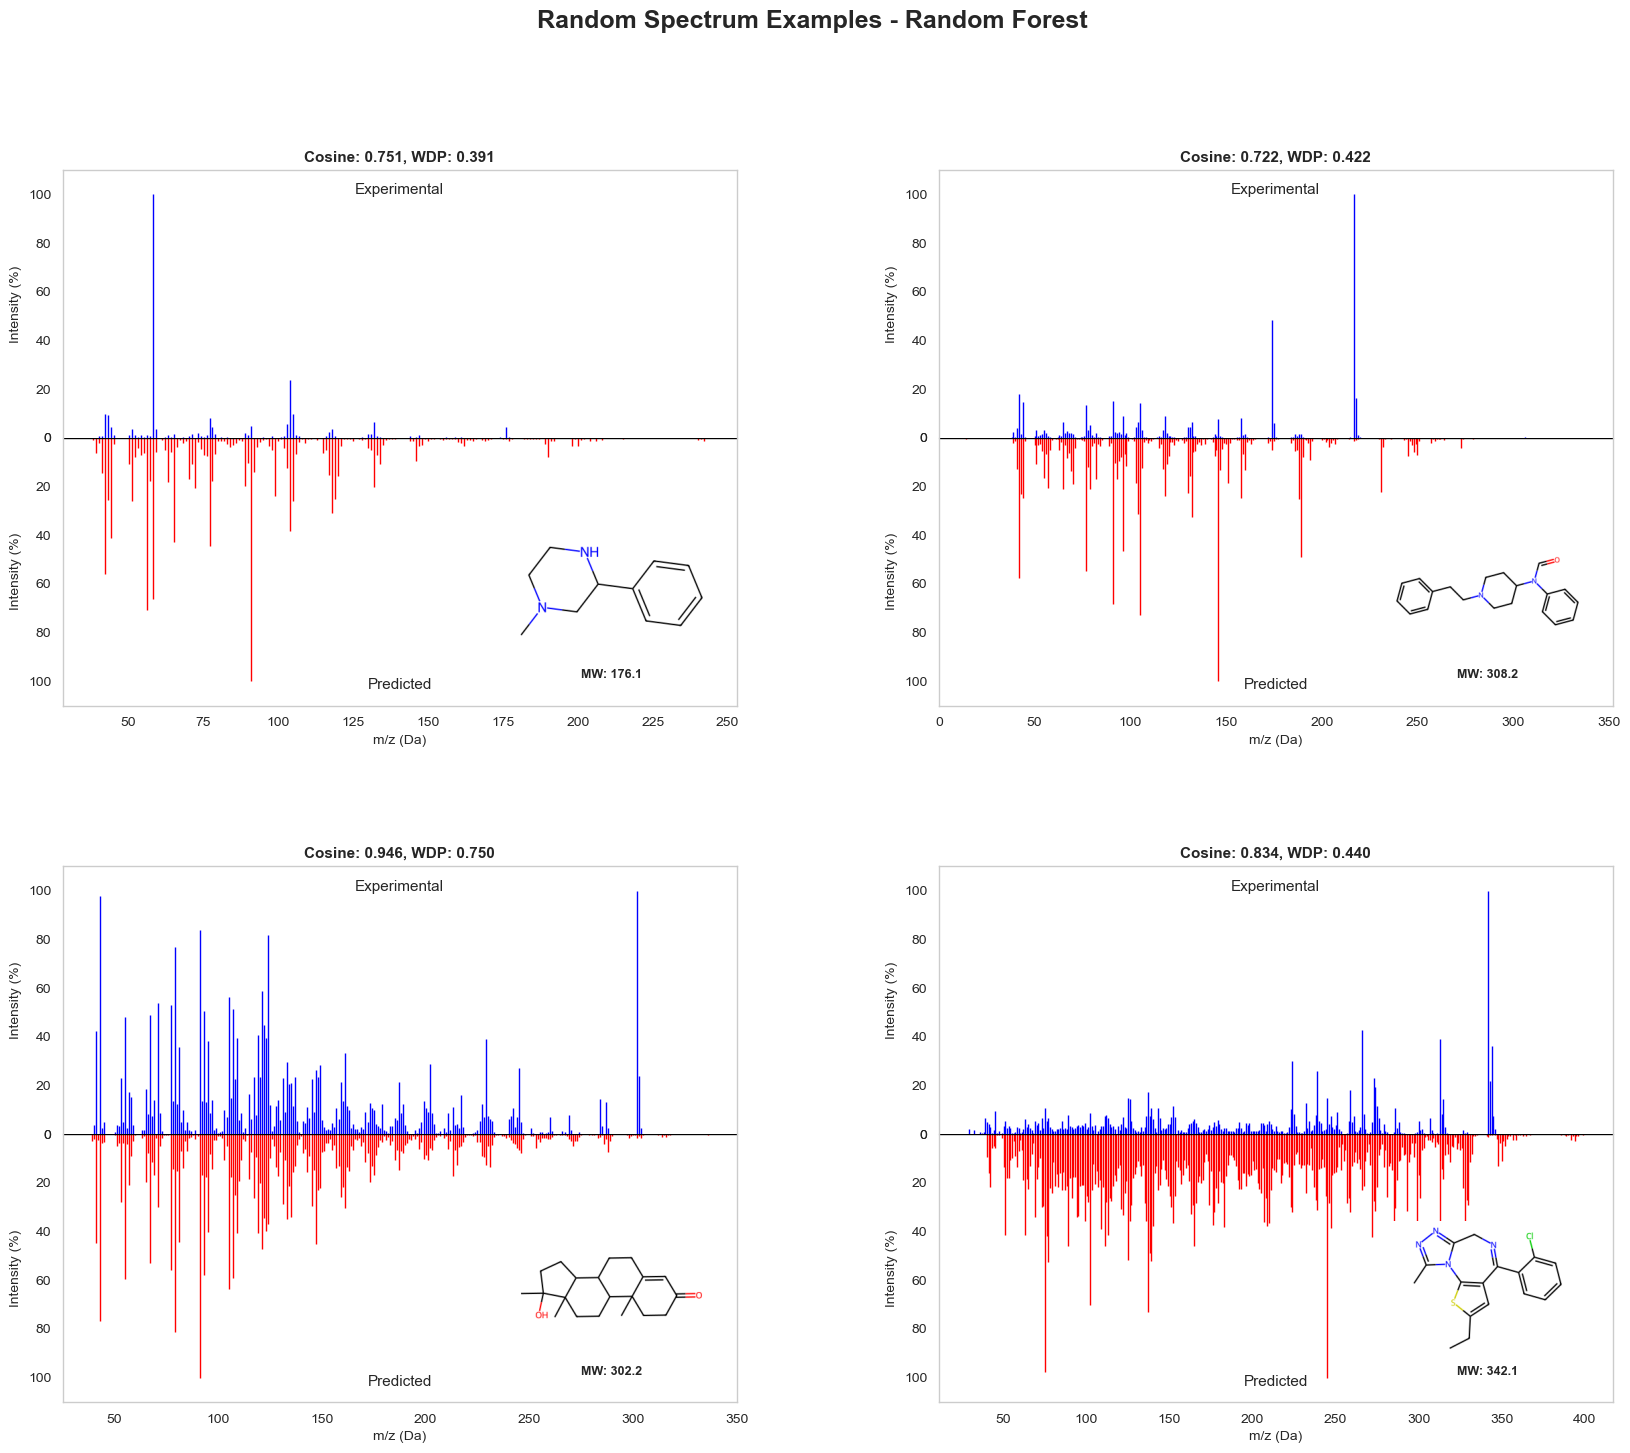


Spectrum visualization complete!


In [90]:
# ============================================================================
# RANDOM SPECTRUM EXAMPLES - COMPLETE VISUALIZATION IN ONE CELL
# ============================================================================

def create_spectrum_grid(results, test_smiles, n_examples=4, model_name="Model"):
    """Create 2x2 grid of random spectrum examples with molecular structures.
    
    Args:
        results: Dictionary from evaluate_model()
        test_smiles: List of SMILES strings for test set
        n_examples: Number of examples to show (max 4)
        model_name: Name for plot title
    """
    # Select random examples
    n_samples = len(results['y_true'])
    random_indices = np.random.choice(n_samples, min(n_examples, n_samples), replace=False)
    
    # Calculate metrics for selected examples
    selected_data = []
    for idx in random_indices:
        y_true = results['y_true'][idx]
        y_pred = results['y_pred'][idx]
        
        # Calculate cosine similarity
        if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
            cosine_sim = 1.0
        elif np.sum(y_true) == 0 or np.sum(y_pred) == 0:
            cosine_sim = 0.0
        else:
            cosine_sim = 1 - cosine(y_true, y_pred)
        
        # Calculate WDP score
        wdp_score = weighted_dot_product(y_true, y_pred)
        
        # Get SMILES
        smiles = test_smiles[idx] if idx < len(test_smiles) else 'N/A'
        
        selected_data.append({
            'y_true': y_true,
            'y_pred': y_pred,
            'cosine_sim': cosine_sim,
            'wdp_score': wdp_score,
            'smiles': smiles,
            'index': idx
        })
    
    # Create figure
    fig = plt.figure(figsize=(20, 16))
    main_gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Print selected examples info
    print(f"\nSelected random examples:")
    
    for i, data in enumerate(selected_data[:4]):
        print(f"  {i+1}. Index {data['index']}: Cosine={data['cosine_sim']:.4f}, WDP={data['wdp_score']:.4f}")
        
        # Calculate position in 2x2 grid
        row = i // 2
        col = i % 2
        
        # Create sub-gridspec for this molecule
        sub_gs = gridspec.GridSpecFromSubplotSpec(2, 1, main_gs[row, col], 
                                                 height_ratios=[1, 1], hspace=0)
        
        ax1 = fig.add_subplot(sub_gs[0])  # Experimental
        ax2 = fig.add_subplot(sub_gs[1])  # Predicted
        
        # Process data (convert from sqrt scale if needed)
        y_true_scaled = data['y_true'] ** 2
        y_pred_scaled = data['y_pred'] ** 2
        
        # Normalize to 0-100 scale
        if np.max(y_true_scaled) > 0:
            y_true_percent = (y_true_scaled / np.max(y_true_scaled)) * 100
        else:
            y_true_percent = y_true_scaled
            
        if np.max(y_pred_scaled) > 0:
            y_pred_percent = (y_pred_scaled / np.max(y_pred_scaled)) * 100
        else:
            y_pred_percent = y_pred_scaled
        
        # Find non-zero peaks for x-axis range
        mz_values = np.arange(len(data['y_true']))
        threshold = 0.1
        true_nonzero = y_true_percent > threshold
        pred_nonzero = y_pred_percent > threshold
        
        all_nonzero = true_nonzero | pred_nonzero
        if np.any(all_nonzero):
            nonzero_indices = np.where(all_nonzero)[0]
            min_mz = nonzero_indices[0]
            max_mz = nonzero_indices[-1]
            mz_range = max_mz - min_mz
            padding = max(10, int(0.05 * mz_range))
            x_min = max(0, min_mz - padding)
            x_max = min(len(data['y_true']), max_mz + padding)
        else:
            x_min = 0
            x_max = min(500, len(data['y_true']))
        
        # Top panel: Experimental spectrum
        if np.any(true_nonzero):
            markerline, stemlines, baseline = ax1.stem(
                mz_values[true_nonzero], 
                y_true_percent[true_nonzero],
                linefmt='b-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax1.set_ylabel('Intensity (%)', fontsize=10)
        ax1.text(0.5, 0.95, 'Experimental', transform=ax1.transAxes,
                 fontsize=11, ha='center', va='top')
        ax1.set_ylim(0, 110)
        ax1.grid(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(bottom=False, labelbottom=False)
        
        # Bottom panel: Predicted spectrum (inverted)
        if np.any(pred_nonzero):
            markerline, stemlines, baseline = ax2.stem(
                mz_values[pred_nonzero], 
                -y_pred_percent[pred_nonzero],
                linefmt='r-', markerfmt=' ', basefmt=' '
            )
            stemlines.set_linewidth(1)
        
        ax2.set_ylim(-110, 0)
        ax2.set_ylabel('Intensity (%)', fontsize=10)
        ax2.set_xlabel('m/z (Da)', fontsize=10)
        ax2.text(0.5, 0.05, 'Predicted', transform=ax2.transAxes,
                 fontsize=11, ha='center', va='bottom')
        
        # Format y-axis to show positive values
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{abs(x):.0f}'))
        ax2.grid(False)
        ax2.spines['top'].set_visible(False)
        ax2.axhline(y=0, color='black', linewidth=1)
        
        # Set x-axis limits
        ax1.set_xlim(x_min, x_max)
        ax2.set_xlim(x_min, x_max)
        
        # Add molecular structure if available
        if data['smiles'] != "N/A" and RDKIT_AVAILABLE:
            try:
                mol = Chem.MolFromSmiles(data['smiles'])
                if mol:
                    mw = Descriptors.ExactMolWt(mol)
                    
                    # Create inset for molecular structure
                    axins = inset_axes(ax2, width="35%", height="50%", loc='lower right', 
                                       bbox_to_anchor=(0, 0.15, 1, 1), bbox_transform=ax2.transAxes)
                    
                    # Draw molecule
                    drawer = rdMolDraw2D.MolDraw2DCairo(300, 200)
                    drawer.DrawMolecule(mol)
                    drawer.FinishDrawing()
                    png = drawer.GetDrawingText()
                    bio = io.BytesIO(png)
                    img = plt.imread(bio, format='png')
                    axins.imshow(img)
                    axins.axis('off')
                    
                    # Add molecular weight
                    axins.text(0.5, -0.08, f'MW: {mw:.1f}', transform=axins.transAxes,
                              fontsize=9, ha='center', va='top', fontweight='bold')
            except:
                pass
        
        # Add title with scores
        title = f"Cosine: {data['cosine_sim']:.3f}, WDP: {data['wdp_score']:.3f}"
        ax1.set_title(title, fontsize=11, fontweight='bold')
    
    # Add overall title
    fig.suptitle(f'Random Spectrum Examples - {model_name}', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ============================================================================
# GENERATE RANDOM SPECTRUM EXAMPLES
# ============================================================================

print("\nGENERATING RANDOM SPECTRUM EXAMPLES (2x2 GRID)")
print("=" * 60)

# Create random spectrum examples
create_spectrum_grid(
    results,
    test_smiles,
    n_examples=4,
    model_name="Random Forest"
)

print("\nSpectrum visualization complete!")

## 9. Neural Network Training

Train a simple neural network model with training history tracking for deep learning visualization.

### Architecture:
- Simple MLP with batch normalization and dropout
- Training with Adam optimizer and learning rate scheduling
- Early stopping based on validation performance

In [91]:
# ============================================================================
# NEURAL NETWORK MODEL AND TRAINING
# ============================================================================

class SimpleMLP(nn.Module):
    """Simple Multi-Layer Perceptron for mass spectrometry prediction."""
    
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        hidden_dims = config['nn']['hidden_dims']
        dropout = config['nn']['dropout']
        use_bn = config['nn']['batch_norm']
        
        layers = []
        dims = [input_dim] + hidden_dims
        
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if use_bn:
                layers.append(nn.BatchNorm1d(dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.ReLU())  # Ensure non-negative outputs
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_neural_network(model, train_loader, val_loader, config, device):
    """Train neural network with history tracking."""
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['nn']['learning_rate'],
        weight_decay=config['nn']['weight_decay']
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=config['nn']['lr_scheduler_factor'],
        patience=config['nn']['lr_scheduler_patience']
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_cosine': [],
        'val_f1': [],
        'lr': []
    }
    
    best_val_cosine = -1
    patience_counter = 0
    
    print("\nTRAINING NEURAL NETWORK")
    print("-" * 40)
    
    for epoch in range(1, config['nn']['epochs'] + 1):
        # Training phase
        model.train()
        train_losses = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['nn']['epochs']}")
        
        for X_batch, y_batch in progress_bar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            
            predictions = model(X_batch)
            loss = F.mse_loss(predictions, y_batch)
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['nn']['gradient_clip'])
            
            optimizer.step()
            train_losses.append(loss.item())
            
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = np.mean(train_losses)
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Validation phase
        if epoch % config['evaluation']['eval_frequency'] == 0:
            model.eval()
            val_losses = []
            all_preds = []
            all_true = []
            
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    
                    predictions = model(X_batch)
                    loss = F.mse_loss(predictions, y_batch)
                    
                    val_losses.append(loss.item())
                    all_preds.append(predictions.cpu().numpy())
                    all_true.append(y_batch.cpu().numpy())
            
            y_pred = np.vstack(all_preds)
            y_true = np.vstack(all_true)
            
            # Calculate metrics
            mean_cosine, _ = cosine_similarity_matrix(y_true, y_pred)
            peak_metrics = peak_detection_metrics(y_true, y_pred, config['evaluation']['peak_threshold'])
            
            history['val_loss'].append(np.mean(val_losses))
            history['val_cosine'].append(mean_cosine)
            history['val_f1'].append(peak_metrics['f1_score'])
            
            # Learning rate scheduling
            scheduler.step(mean_cosine)
            
            print(f"  Val Loss: {np.mean(val_losses):.4f}, Cosine: {mean_cosine:.4f}, F1: {peak_metrics['f1_score']:.4f}")
            
            # Early stopping check
            if mean_cosine > best_val_cosine:
                best_val_cosine = mean_cosine
                patience_counter = 0
                # Save best model
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
            
            if patience_counter >= config['nn']['early_stopping_patience']:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\nTraining complete. Best validation cosine: {best_val_cosine:.4f}")
    
    return model, history

# Create data loaders
print("\nCreating PyTorch data loaders...")
train_loader, val_loader, test_loader = create_torch_dataloaders(
    X_train_scaled, y_train_transformed,
    X_val_scaled, y_val_transformed,
    X_test_scaled, y_test_transformed,
    batch_size=MASTER_CONFIG['nn']['batch_size']
)

# Create and train neural network
nn_model = SimpleMLP(input_dim, output_dim, MASTER_CONFIG).to(DEVICE)
print(f"Neural network parameters: {sum(p.numel() for p in nn_model.parameters()):,}")

# Train the model
nn_model, nn_history = train_neural_network(nn_model, train_loader, val_loader, MASTER_CONFIG, DEVICE)

# Evaluate on test set
nn_model.eval()
nn_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(DEVICE)
        pred = nn_model(X_batch)
        nn_predictions.append(pred.cpu().numpy())

y_test_pred_nn = np.vstack(nn_predictions)

# Calculate test metrics
test_cosine_nn, _ = cosine_similarity_matrix(y_test_transformed, y_test_pred_nn)
test_peak_metrics_nn = peak_detection_metrics(y_test_transformed, y_test_pred_nn, MASTER_CONFIG['evaluation']['peak_threshold'])

print(f"\nNeural Network Test Performance:")
print(f"  Cosine Similarity: {test_cosine_nn:.4f}")
print(f"  Peak F1 Score: {test_peak_metrics_nn['f1_score']:.4f}")


Creating PyTorch data loaders...
Neural network parameters: 17,505,268

TRAINING NEURAL NETWORK
----------------------------------------


Epoch 5/50: 100%|██████████| 34/34 [00:00<00:00, 40.36it/s, loss=0.0106]


  Val Loss: 0.0126, Cosine: 0.2287, F1: 0.1345


Epoch 10/50: 100%|██████████| 34/34 [00:00<00:00, 44.56it/s, loss=0.0086]


  Val Loss: 0.0097, Cosine: 0.4689, F1: 0.5711


Epoch 15/50: 100%|██████████| 34/34 [00:00<00:00, 48.77it/s, loss=0.0060]


  Val Loss: 0.0085, Cosine: 0.5681, F1: 0.6471


Epoch 20/50: 100%|██████████| 34/34 [00:00<00:00, 69.65it/s, loss=0.0053]


  Val Loss: 0.0081, Cosine: 0.6134, F1: 0.6723


Epoch 25/50: 100%|██████████| 34/34 [00:00<00:00, 81.10it/s, loss=0.0048]


  Val Loss: 0.0079, Cosine: 0.6414, F1: 0.6883


Epoch 30/50: 100%|██████████| 34/34 [00:00<00:00, 81.00it/s, loss=0.0043]


  Val Loss: 0.0077, Cosine: 0.6573, F1: 0.7054


Epoch 35/50: 100%|██████████| 34/34 [00:00<00:00, 79.48it/s, loss=0.0045]


  Val Loss: 0.0074, Cosine: 0.6868, F1: 0.7222


Epoch 40/50: 100%|██████████| 34/34 [00:00<00:00, 85.61it/s, loss=0.0045]


  Val Loss: 0.0075, Cosine: 0.6871, F1: 0.7258


Epoch 45/50: 100%|██████████| 34/34 [00:00<00:00, 80.06it/s, loss=0.0032]


  Val Loss: 0.0074, Cosine: 0.7027, F1: 0.7268


Epoch 50/50: 100%|██████████| 34/34 [00:00<00:00, 79.74it/s, loss=0.0035]


  Val Loss: 0.0073, Cosine: 0.6994, F1: 0.7285

Training complete. Best validation cosine: 0.7027

Neural Network Test Performance:
  Cosine Similarity: 0.6928
  Peak F1 Score: 0.7356


## 10. Deep Learning Training Plots (2x2)

**DEEP LEARNING VISUALIZATION IN ONE CELL** - Modify and re-run this cell to update training plots.

Creates a 2x2 grid showing training history for neural network models.

### Plot Descriptions:

**1. Loss Curves** (Top-Left):
- Training loss (blue)
- Validation loss (orange)
- Shows convergence and overfitting

**2. Cosine Similarity** (Top-Right):
- Validation cosine similarity over epochs
- Primary performance metric

**3. Peak Detection F1** (Bottom-Left):
- Validation F1 score for peak detection
- Shows improvement in peak prediction accuracy

**4. Learning Rate Schedule** (Bottom-Right):
- Learning rate changes during training
- Shows adaptive learning rate scheduling


GENERATING DEEP LEARNING TRAINING PLOTS (2x2)


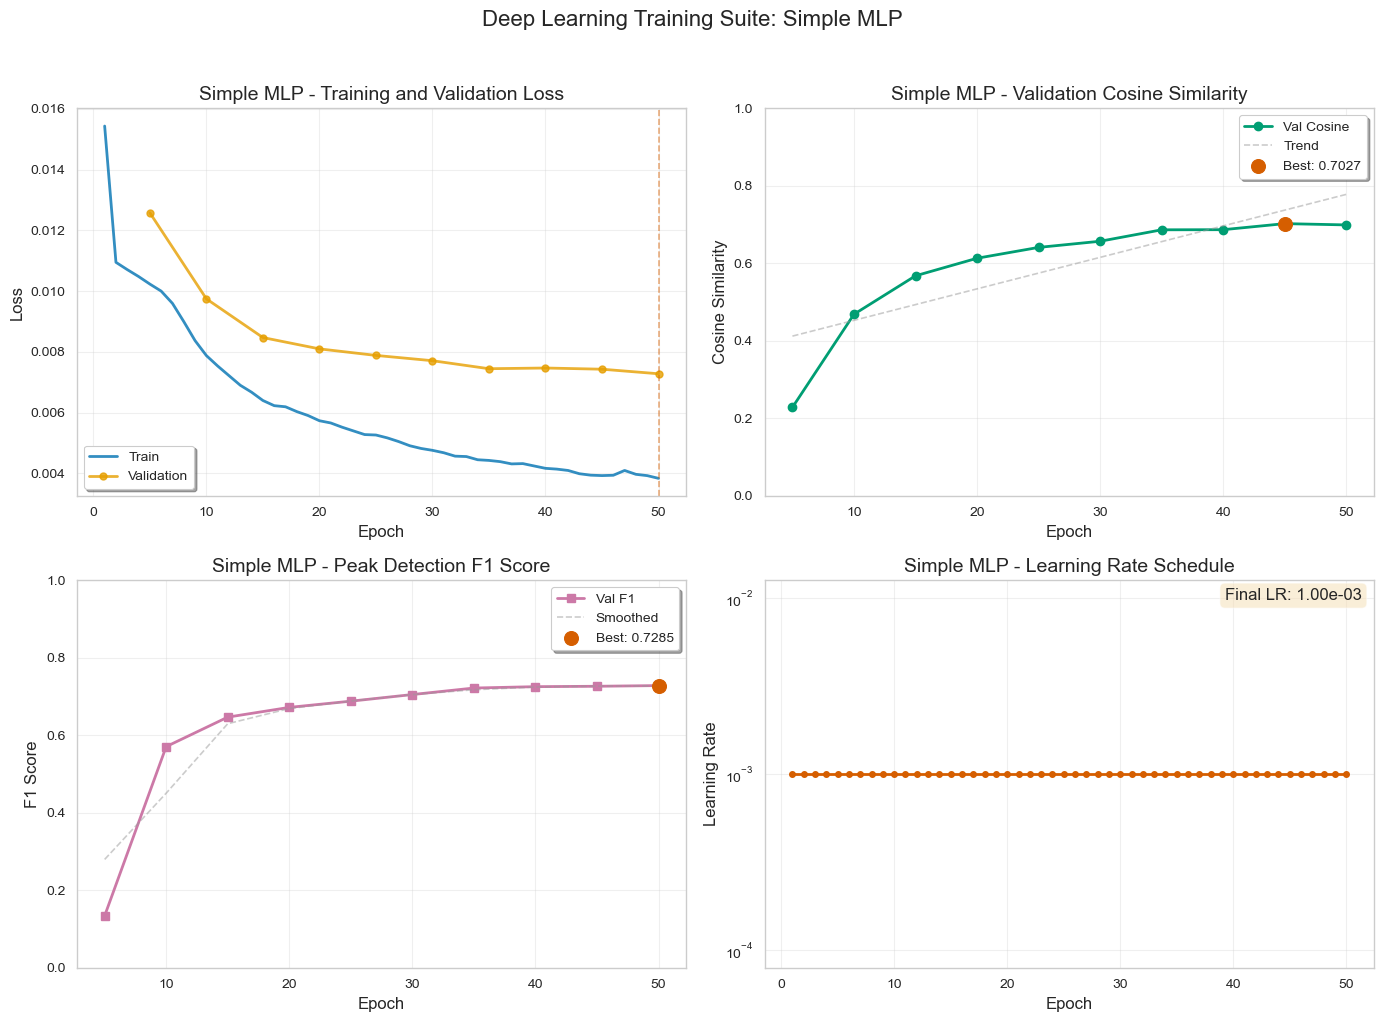


Training Summary:
  Total epochs: 50
  Best val cosine: 0.7027
  Best val F1: 0.7285
  Final train loss: 0.0038
  Final val loss: 0.0073
  Final learning rate: 1.00e-03

Deep learning visualization complete!


In [92]:
# ============================================================================
# DEEP LEARNING 2x2 TRAINING PLOTS - ALL PLOTTING CODE IN ONE CELL
# ============================================================================

def plot_training_history(history, model_name="Neural Network"):
    """Create 2x2 deep learning training visualization.
    
    Args:
        history: Dictionary with training history from neural network
        model_name: Name for plot title
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ---------- Top-Left: Loss Curves ----------
    ax = axes[0, 0]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], label='Train', color=PALETTE["blue"], linewidth=2, alpha=0.8)
    
    if history['val_loss']:
        # Interpolate validation loss to match training epochs if evaluated less frequently
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_loss'])]
        ax.plot(val_epochs, history['val_loss'][:len(val_epochs)], 
               label='Validation', color=PALETTE["orange"], linewidth=2, alpha=0.8, marker='o', markersize=5)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name} - Training and Validation Loss')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    # Highlight best epoch if validation loss exists
    if history['val_loss']:
        best_epoch_idx = np.argmin(history['val_loss'])
        best_epoch = val_epochs[best_epoch_idx]
        ax.axvline(x=best_epoch, color=PALETTE["vermillion"], linestyle='--', alpha=0.5, label='Best')
    
    # ---------- Top-Right: Cosine Similarity ----------
    ax = axes[0, 1]
    if history['val_cosine']:
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_cosine'])]
        ax.plot(val_epochs, history['val_cosine'][:len(val_epochs)], 
               color=PALETTE["green"], linewidth=2, marker='o', markersize=6, label='Val Cosine')
        
        # Add trend line
        z = np.polyfit(val_epochs, history['val_cosine'][:len(val_epochs)], 1)
        p = np.poly1d(z)
        ax.plot(val_epochs, p(val_epochs), linestyle='--', color=PALETTE["grey"], alpha=0.5, label='Trend')
        
        # Highlight best
        best_cosine_idx = np.argmax(history['val_cosine'])
        best_cosine = history['val_cosine'][best_cosine_idx]
        best_epoch = val_epochs[min(best_cosine_idx, len(val_epochs)-1)]
        ax.scatter([best_epoch], [best_cosine], color=PALETTE["vermillion"], s=100, zorder=5, 
                  label=f'Best: {best_cosine:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'{model_name} - Validation Cosine Similarity')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    # ---------- Bottom-Left: Peak Detection F1 ----------
    ax = axes[1, 0]
    if history['val_f1']:
        val_epochs = np.array(range(MASTER_CONFIG['evaluation']['eval_frequency'], 
                                    len(history['train_loss']) + 1, 
                                    MASTER_CONFIG['evaluation']['eval_frequency']))
        val_epochs = val_epochs[:len(history['val_f1'])]
        ax.plot(val_epochs, history['val_f1'][:len(val_epochs)], 
               color=PALETTE["purple"], linewidth=2, marker='s', markersize=6, label='Val F1')
        
        # Add smoothed curve
        if len(history['val_f1']) > 3:
            from scipy.ndimage import uniform_filter1d
            smoothed = uniform_filter1d(history['val_f1'][:len(val_epochs)], size=3, mode='nearest')
            ax.plot(val_epochs, smoothed, linestyle='--', color=PALETTE["grey"], 
                   alpha=0.5, label='Smoothed')
        
        # Highlight best
        best_f1_idx = np.argmax(history['val_f1'])
        best_f1 = history['val_f1'][best_f1_idx]
        best_epoch = val_epochs[min(best_f1_idx, len(val_epochs)-1)]
        ax.scatter([best_epoch], [best_f1], color=PALETTE["vermillion"], s=100, zorder=5,
                  label=f'Best: {best_f1:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'{model_name} - Peak Detection F1 Score')
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    # ---------- Bottom-Right: Learning Rate Schedule ----------
    ax = axes[1, 1]
    if history['lr']:
        epochs = range(1, len(history['lr']) + 1)
        ax.plot(epochs, history['lr'], color=PALETTE["vermillion"], linewidth=2, 
               marker='o', markersize=4)
        
        # Mark LR reductions
        lr_changes = []
        for i in range(1, len(history['lr'])):
            if history['lr'][i] < history['lr'][i-1]:
                lr_changes.append(i)
        
        for change_epoch in lr_changes:
            ax.axvline(x=change_epoch, color=PALETTE["grey"], linestyle=':', alpha=0.5)
            ax.annotate(f'LR↓', xy=(change_epoch, history['lr'][change_epoch]), 
                       xytext=(change_epoch, history['lr'][change_epoch]*2),
                       arrowprops=dict(arrowstyle='->', color=PALETTE["grey"], alpha=0.5),
                       fontsize=9, ha='center')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title(f'{model_name} - Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Add text annotation with final LR
    if history['lr']:
        final_lr = history['lr'][-1]
        ax.text(0.98, 0.98, f'Final LR: {final_lr:.2e}', transform=ax.transAxes,
               ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall title and layout
    plt.suptitle(f'Deep Learning Training Suite: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ============================================================================
# GENERATE DEEP LEARNING TRAINING PLOTS
# ============================================================================

print("\nGENERATING DEEP LEARNING TRAINING PLOTS (2x2)")
print("=" * 60)

# Plot the training history
plot_training_history(nn_history, model_name="Simple MLP")

# Print training summary
print("\nTraining Summary:")
print(f"  Total epochs: {len(nn_history['train_loss'])}")
print(f"  Best val cosine: {max(nn_history['val_cosine']):.4f}")
print(f"  Best val F1: {max(nn_history['val_f1']):.4f}")
print(f"  Final train loss: {nn_history['train_loss'][-1]:.4f}")
if nn_history['val_loss']:
    print(f"  Final val loss: {nn_history['val_loss'][-1]:.4f}")
print(f"  Final learning rate: {nn_history['lr'][-1]:.2e}")

print("\nDeep learning visualization complete!")